### Imports and Settings

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import SAGA
from SAGA.database import FitsTable
from easyquery import Query
from easyquery import QueryMaker

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}

plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['legend.frameon'] = False
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 4

### Load SAGA Data

In [25]:
def vproj_from_specz(spec_z,host_vhost,c=3e5):
    return c*spec_z-host_vhost

In [4]:
saga = SAGA.QuickStart()
saga.set_default_base_version("paper2")

hosts = saga.host_catalog.load(include_stats=True)
paper1_hosts = np.array(['nsa166313', 'nsa147100', 'nsa165536', 'nsa61945', 'nsa132339',
                         'nsa149781', 'nsa33446', 'nsa150887'])

SAGA `shared_dir` set to /Users/eon/Documents/PaperII
SAGA `local_dir`  set to /Users/eon/Documents/PaperII


In [6]:
completed_hosts = saga.host_catalog.load(query="paper2_complete", include_stats="remote")
observed_hosts = saga.host_catalog.load(query="paper2_observed", include_stats="remote")
bright_completed_hosts = saga.host_catalog.load(query="paper2_bright_complete", include_stats="remote")

In [7]:
verylowz_url = "https://www.dropbox.com/sh/7qeuqkq0c591k2g/AADvj3rqLvFWMTZICBOG33-2a/saga_verylowz_latest.fits?dl=1"
verylowz = FitsTable(verylowz_url).read()
verylowz_completed_hosts = QueryMaker.in1d("HOSTID", completed_hosts["HOSTID"]).filter(verylowz)

In [42]:
rproj_limit = 300.
vproj_limit = 275.
confusion_limit = 10.

satellite_idx = (verylowz_completed_hosts['RHOST_KPC']<rproj_limit) &\
                (np.abs(vproj_from_specz(verylowz_completed_hosts['SPEC_Z'],
                                         verylowz_completed_hosts['HOST_VHOST']))<vproj_limit) &\
                (verylowz_completed_hosts['RHOST_KPC']>confusion_limit)

field_idx = ~((verylowz_completed_hosts['RHOST_KPC']<rproj_limit) &\
                (np.abs(vproj_from_specz(verylowz_completed_hosts['SPEC_Z'],
                                         verylowz_completed_hosts['HOST_VHOST']))<vproj_limit)) &\
                (verylowz_completed_hosts['RHOST_KPC']>confusion_limit)

### Load Simulation Data

In [49]:
h = 0.7

N = 8
v_bins = np.linspace(-600,600,N)
dist_bins = np.linspace(0,3.75,N)

with open('EON_data/rvir_dictionary.pickle', 'rb') as handle:
    rvir_dictionary = pickle.load(handle)
    
with open('EON_data/vesc_dictionary.pickle', 'rb') as handle:
    vesc_dictionary = pickle.load(handle)
    
interloper_map = np.load('EON_data/interloper_map.npy')
interloper_map_scaled = np.load('EON_data/interloper_map_scaled.npy')

mean = np.load('EON_data/sim_vesc_mean.npy')
std = np.load('EON_data/sim_vesc_std.npy')

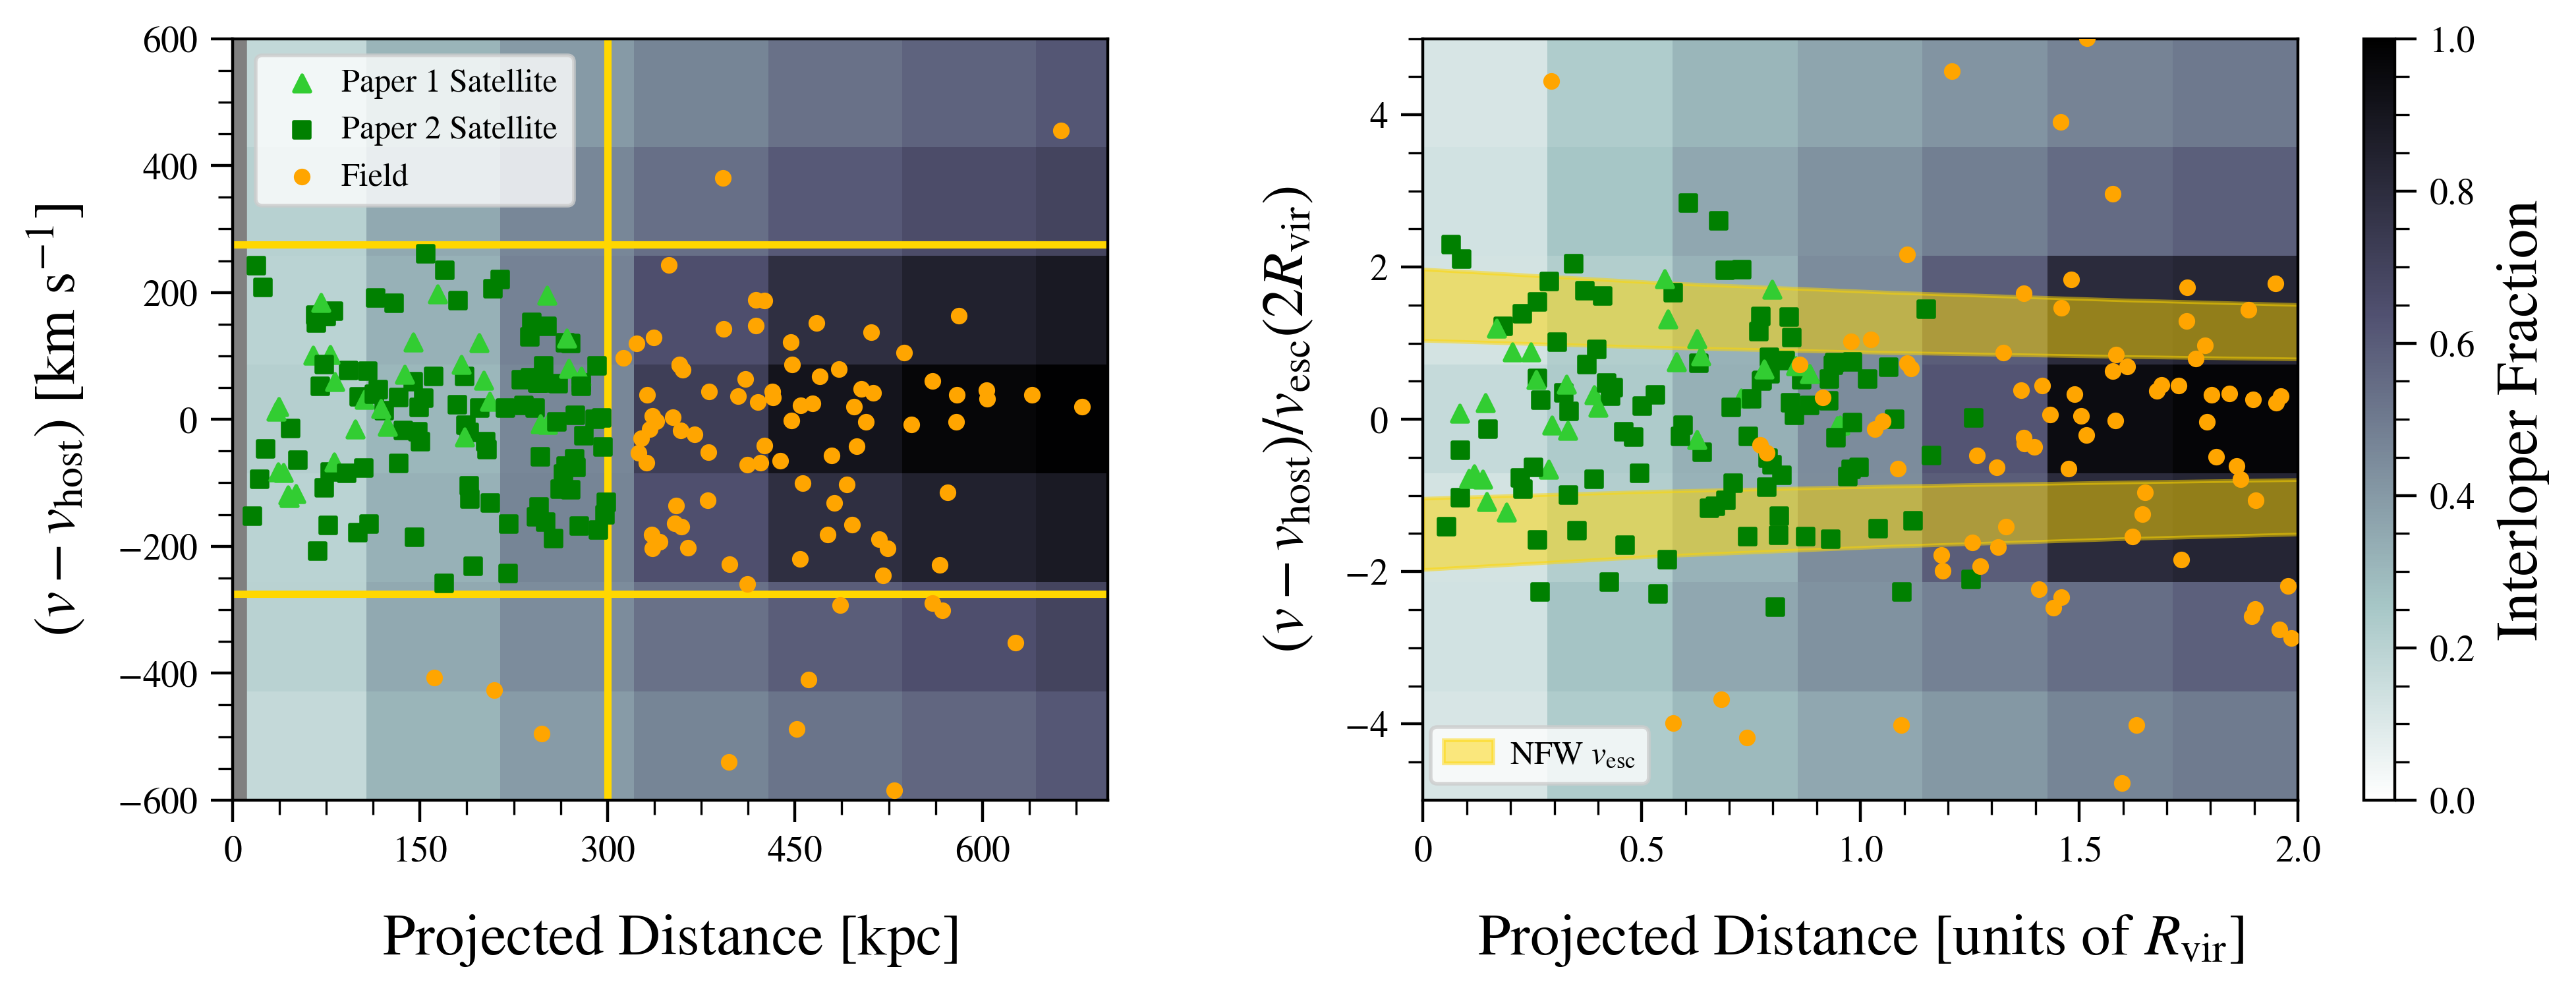

In [50]:
fig = plt.figure(figsize=(10,4))

#Left panel
ax1 = plt.subplot(1,2,1)

sc = plt.imshow(interloper_map, extent=[0,750,-600,600], aspect='auto', cmap='bone_r', vmin=0.0,vmax=1.0)

plt.plot(np.linspace(0,800,10),vproj_limit*np.ones(10),ls='-',c='gold',lw=2,zorder=1)
plt.plot(np.linspace(0,800,10),-1.*vproj_limit*np.ones(10),ls='-',c='gold',lw=2,zorder=1)
plt.plot(rproj_limit*np.ones(10),np.linspace(-600,600,10),ls='-',c='gold',lw=2,zorder=1)

plt.fill_between(np.linspace(0,confusion_limit,10),-600*np.ones(10),600*np.ones(10),
                 edgecolor='gray',facecolor='gray',zorder=1)

for sat in verylowz_completed_hosts[satellite_idx]:
    if sat['HOSTID'] in paper1_hosts:
        paper1 = plt.scatter(sat['RHOST_KPC'],vproj_from_specz(sat['SPEC_Z'],sat['HOST_VHOST']),
           c='limegreen',marker='^',s=20,zorder=999,label=r'Paper 1 Satellite')
    else:
        paper2 = plt.scatter(sat['RHOST_KPC'],vproj_from_specz(sat['SPEC_Z'],sat['HOST_VHOST']),
           c='g',marker='s',s=17.5,zorder=999,label=r'Paper 2 Satellite')

field = plt.scatter(verylowz_completed_hosts['RHOST_KPC'][field_idx],
                    vproj_from_specz(verylowz_completed_hosts['SPEC_Z'][field_idx],
                                     verylowz_completed_hosts['HOST_VHOST'][field_idx]),
                    c='orange',marker='o',s=12.5,label=r'Field',zorder=999)

plt.xlim(0,700)
plt.ylim(-600,600)

plt.xticks([0,150,300,450,600],[r'$0$',r'$150$',r'$300$',r'$450$',r'$600$'],fontsize=10)
plt.yticks([-600,-400,-200,0,200,400,600],[r'$-600$',r'$-400$',r'$-200$',r'$0$',r'$200$',r'$400$',r'$600$'],
           fontsize=10)

plt.xlabel(r'Projected Distance [$\rm{kpc}$]', fontsize=16,labelpad=12)
plt.ylabel(r'$(v-v_{\rm{host}})\ [\mathrm{km\ s}^{-1}]$', fontsize=16,labelpad=8)

leg = plt.legend(loc=2,handles=[paper1,paper2,field],fontsize=9,frameon=True,
                 handletextpad=0.3,bbox_to_anchor=(0.0075,1.0))
leg.set_zorder(999)
for t in leg.get_texts():
    t.set_ha('left')
    t.set_position((-5,0))

divider2 = make_axes_locatable(ax1)
cax2 = divider2.append_axes("right", size="3.5%", pad=0.25)
cax2.axis('off')

#Right panel
ax2 = plt.subplot(1,2,2)

sc = plt.imshow(interloper_map_scaled, extent=[0,2,-5,5], aspect='auto', cmap='bone_r', vmin=0.0,vmax=1.0)

plt.fill_between(dist_bins,(mean-std)/(mean[-1]),
                  (mean+std)/(mean[-1]),facecolor='gold',
                 edgecolor='gold',alpha=0.5,zorder=1,label=r'NFW $v_{\mathrm{esc}}$',rasterized=True)

plt.fill_between(dist_bins,(-1.*mean-1.*std)/(mean[-1]),
                  (-1.*mean+1.*std)/((mean[-1])),facecolor='gold',
                 edgecolor='gold',alpha=0.5,zorder=1,rasterized=True)

for sat in verylowz_completed_hosts[satellite_idx]:
    if sat['HOSTID'] in paper1_hosts:
        plt.scatter(sat['RHOST_KPC']/(rvir_dictionary[sat['HOSTID']]/h),
                    vproj_from_specz(sat['SPEC_Z'],sat['HOST_VHOST'])/vesc_dictionary[sat['HOSTID']],
                    c='limegreen',marker='^',s=20,zorder=999)
    else:
        plt.scatter(sat['RHOST_KPC']/(rvir_dictionary[sat['HOSTID']]/h),
                    vproj_from_specz(sat['SPEC_Z'],sat['HOST_VHOST'])/vesc_dictionary[sat['HOSTID']],
                    c='g',marker='s',s=17.5,zorder=999)
    
for sat in verylowz_completed_hosts[field_idx]:
    plt.scatter(sat['RHOST_KPC']/(rvir_dictionary[sat['HOSTID']]/h),
                vproj_from_specz(sat['SPEC_Z'],sat['HOST_VHOST'])/vesc_dictionary[sat['HOSTID']],
                c='orange',marker='o',s=12.5,zorder=999)
    
plt.xlim(0,2)
plt.ylim(-5,5)

plt.xticks([0,0.5,1.0,1.5,2.0],[r'$0$',r'$0.5$',r'$1.0$',r'$1.5$',r'$2.0$'],fontsize=10)
plt.yticks([-4,-2,0,2,4],[r'$-4$',r'$-2$',r'$0$',r'$2$',r'$4$'],fontsize=10)

plt.xlabel(r'Projected Distance [units of $R_{\rm{vir}}$]', fontsize=16,labelpad=12)
plt.ylabel(r'$(v-v_{\rm{host}})/v_{\rm{esc}}(2R_{\rm{vir}})$', fontsize=16,labelpad=8)

leg = plt.legend(loc=3,fontsize=9,frameon=True,handletextpad=0.5,handlelength=1.5,bbox_to_anchor=(-0.01,0.0))
leg.set_zorder(999)
    
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="3.5%", pad=0.25)
cbar = plt.colorbar(sc,cax=cax)
cbar.set_label(r'Interloper Fraction',size=16,labelpad=6)
cbar.set_ticks([0,0.2,0.4,0.6,0.8,1.0],[r'$0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'])
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('vdiff.pdf')
plt.show()